![spam](img/JB2.png)

In [1]:
import warnings
warnings.filterwarnings('ignore')

## 1.   Importing libraries and loading data

In [1]:
# Basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Normalization  libraries
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error, r2_score

# Tensorflow with keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Easy graphs with plotly
import plotly.express as px
import plotly.graph_objects as go

# Matplotlib plots look like
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15,7)
import pickle as pk

import scipy
from scipy import stats


In [3]:
# Importing tensors
X_train = np.load('./outputs/split/X_train.npy')
X_val = np.load('./outputs/split/X_val.npy')
X_test = np.load('./outputs/split/X_test.npy')
y_train = np.load('./outputs/split/y_train.npy')
y_val = np.load('./outputs/split/y_val.npy')
y_test = np.load('./outputs/split/y_test.npy')

## 2.   Setting the model

<summary>
    <font size="4" color="orange"><b>1.1 Setting the parameters according to the tensors created in JNB1</b></font>
</summary>

In [4]:
n_pasado = (24 * 7)+12
n_futuro = 24
n_salto = 12 

nom_attr = ['DEMANDA', 
            'MES', 
            'DIA', 
            'HORA',
            'LUNES_FESTIVO',
            'MARTES_POSTFESTIVO', 
            'SEMANA_SANTA', 
            '1_MAYO', 
            '10_MAYO', 
            '16_SEP',
            '2_NOV.', 
            'PRE-NAVIDAD_Y_NEW_YEAR', 
            'NAVIDAD_Y_NEW_YEAR',
            'POST-NAVIDAD_Y_NEW_YEAR' ]
n_attr = len(nom_attr)

<summary>
    <font size="4" color="orange"><b>1.2 Configuring the LSTM Encoder-Decoder model</b></font>
</summary>

MODEL 

<img src="img/encoders2_fig.png" alt="drawing" width="700"/>

LSTM UNIT

<img src="img/lstm_unit.png" alt="drawing" width="400"/>

Such that:

* Forget Gate $F$: a NN with sigmoid 
* Candidate layer $C$: a NN with Tanh
* Input Gate $I$: a NN with sigmoid
* Output Gate $O$: a NN with sigmoid
* Hidden state $h$: a vector, in our case we set $h\in\mathbb{R}^{100}$
* Memory state $c$: a vector, in our case we set $c\in\mathbb{R}^{100}$


In [5]:
# Configuration of the encoder
encoder_inputs = layers.Input(shape=(n_pasado, n_attr))

encoder_l1 = layers.LSTM(100, return_state=True)# 100: dimension of hidden states
encoder_outputs1 = encoder_l1(encoder_inputs)

encoder_states1 = encoder_outputs1[1:]

Metal device set to: Apple M1 Max


2022-05-25 09:24:32.347853: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-25 09:24:32.348041: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [6]:
# Configuration of the encoder
decoder_rvec = layers.RepeatVector(n_futuro) # repeat vector 24 times
decoder_inputs = decoder_rvec(encoder_outputs1[0])

decoder_l1 = layers.LSTM(100, return_sequences=True)
decoder_l1_output = decoder_l1(decoder_inputs, initial_state=encoder_states1)

decoder_l2 = layers.TimeDistributed(layers.Dense(1)) # just one dense layer
decoder_outputs = decoder_l2(decoder_l1_output)

In [7]:
modelo = keras.models.Model(encoder_inputs, decoder_outputs)
modelo.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 180, 14)]    0           []                               
                                                                                                  
 lstm (LSTM)                    [(None, 100),        46000       ['input_1[0][0]']                
                                 (None, 100),                                                     
                                 (None, 100)]                                                     
                                                                                                  
 repeat_vector (RepeatVector)   (None, 24, 100)      0           ['lstm[0][0]']                   
                                                                                              

## 3.   Training the model

Let $F_\theta: {\rm Mat}_{180\times 18}(\mathbb{R})\rightarrow \mathbb{R}^{24}$ be the nonlinear mapping given by the LSTM model where $\theta \in\mathbb{R}^{128,101}$ is the vector of parameters to fit

The *training*, *validation* and *test* sets are codificated by the tensors $X_{180\times 18\times m}$ and $Y_{24\times 1\times m}$ for $m = m_{\rm train}, m_{\rm val}, m_{\rm test}$, as above. This tensors are, in each case,  just $m$ samples of the ordered pairs in ${\rm Mat}_{180\times 18}(\mathbb{R})\times \mathbb{R}^{24}$: $$\{(X^1,Y^1),(X^2,Y^2)
\dots(X^m,Y^m)\}.$$



<summary>
    <font size="3" color="palevioletred"><b>Loss function</b></font>
</summary>

For fixed $\theta$ and tensor pair $X$ and $Y$, we set the **loss function** in terms of the MAE metric with the $\ell_1$ norm: 

$${\rm Loss}(X) = \frac{1}{m}\sum_{k=1}^m{\|F_\theta(X^k)-Y^k\|_1}$$



<summary>
    <font size="3" color="palevioletred"><b>Hyperparameters</b></font>
</summary>

* **epochs** (upper bound) = 25: An epoch is when an entire training set is passed  through the NN only once.

* **batch size** = 32: Total number of training examples present in a single batch.

* **patience** = 5:  Number of epochs with no improvement after which training will be stopped, in our case with respect to ${\rm Loss}(X_{\rm val})$.

* **learning rate** $\alpha_{\rm epoch} = 1\times 10^{-3} \times 0.9 ^{\rm epoch}$

<summary>
    <font size="3" color="palevioletred"><b>Training process</b></font>
</summary>

<img src="img/minibatch.png" alt="drawing" width="550"/>

In [8]:
## Sets the function for the rate learning in such a way that earning rate is smaller en each epoch
reduce_lr = keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x) 

## During the run, the models of "best" result are stored according to "val_loss"

path_checkpoint = "./outputs/h5/model_checkpoint.h5"
modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

## Setting the number of epochs with no improvement after which training will be stopped, 
## with respect to "val_loss". This is to avoid overfitting.
es_callback = keras.callbacks.EarlyStopping(
    monitor="val_loss", 
    min_delta=0, 
    patience=5 ### probar con menos
    
)

modelo.compile(
    optimizer=keras.optimizers.Adam(),  ### un tipo de descenso de gradiente más eficiente 'momento-inercia'
    loss="mae", ### determinación de la función de costo
    metrics=['accuracy']
)

history = modelo.fit(
    X_train,
    y_train,
    epochs=25,
    validation_data=(X_val,y_val),
    batch_size=32,
    callbacks=[reduce_lr, es_callback]
) ### guardar este history para graficar

Epoch 1/25


2022-05-25 09:24:35.104911: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-05-25 09:24:36.313770: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-25 09:24:36.536991: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-25 09:24:37.758427: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-25 09:24:38.886169: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-25 09:24:40.149192: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3829/3829 [==============================] - ETA: 0s - loss: 0.0475 - accuracy: 1.9592e-04

2022-05-25 09:27:14.197681: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-25 09:27:14.269981: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-25 09:27:14.461436: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3829/3829 [==============================] - 161s 41ms/step - loss: 0.0475 - accuracy: 1.9592e-04 - val_loss: 0.0239 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 2/25
3829/3829 [==============================] - 156s 41ms/step - loss: 0.0367 - accuracy: 1.9592e-04 - val_loss: 0.0366 - val_accuracy: 0.0000e+00 - lr: 9.0000e-04
Epoch 3/25
3829/3829 [==============================] - 160s 42ms/step - loss: 0.0347 - accuracy: 1.9592e-04 - val_loss: 0.0179 - val_accuracy: 0.0000e+00 - lr: 8.1000e-04
Epoch 4/25
3829/3829 [==============================] - 160s 42ms/step - loss: 0.0329 - accuracy: 1.9592e-04 - val_loss: 0.0211 - val_accuracy: 0.0000e+00 - lr: 7.2900e-04
Epoch 5/25
3829/3829 [==============================] - 161s 42ms/step - loss: 0.0312 - accuracy: 1.9592e-04 - val_loss: 0.0202 - val_accuracy: 0.0000e+00 - lr: 6.5610e-04
Epoch 6/25
3829/3829 [==============================] - 163s 43ms/step - loss: 0.0301 - accuracy: 1.9592e-04 - val_loss: 0.0180 - val_accuracy: 0.0000e+00 

## 4.   Model validation

In [9]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


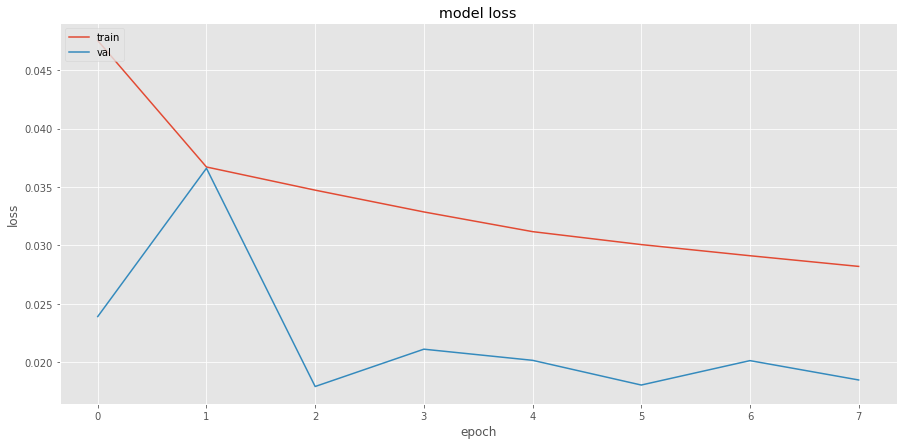

In [10]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [11]:
## 5.   Model test results

In [28]:
df_test = pd.read_csv('./outputs/PCA/scaled_test.csv')
#del df_test["Unnamed: 0"]

In [29]:
y_est = modelo.predict(X_test)
y_test[:,:,0].ravel().shape, y_est[:,:,0].ravel().shape, df_test['FECHA-HORA'][n_pasado + n_salto:].shape

((8568,), (8568,), (8568,))

In [30]:
scalers = pk.load(open("./outputs/DataProcessing/scalers.pkl",'rb'))

In [31]:
scaler = scalers['DEMANDA']
yr = scaler.inverse_transform(y_test[:,:,0].ravel().reshape(-1, 1))
yh = scaler.inverse_transform(y_est[:,:,0].ravel().reshape(-1, 1))

In [32]:
df_est = pd.DataFrame({
    "REAL": yr.ravel(),
    "ESTIMADO": yh.ravel(),
    "FECHA-HORA": df_test["FECHA-HORA"][n_pasado + n_salto:]     
})

In [33]:
df_est['FECHA-HORA']= pd.to_datetime(df_est['FECHA-HORA'])
df_est["HORA"] = df_est['FECHA-HORA'].dt.hour

In [34]:
real=[]
estimada =[]

df_est_result = pd.DataFrame(columns=['FECHA-HORA',"MAPE"])

for i, row in df_est.iterrows():

    n = row['HORA']
    
    real.append(row['REAL'])
    estimada.append(row['ESTIMADO'])
    
   
    if n == 23:
        df_est_result = df_est_result.append(pd.DataFrame({"FECHA-HORA": row['FECHA-HORA'],
                                           "MAPE": (mean_absolute_percentage_error(real, estimada))*100, 
                                           "R2": stats.pearsonr(real, estimada)[0]}, 
                                            index=[0]), ignore_index=True)
        n=0
        
        real=[]
        estimada =[]
    n+=1


In [35]:
df_est_result

,FECHA-HORA,MAPE,R2
0,2021-05-08 23:00:00,0.799191,0.995070
1,2021-05-09 23:00:00,2.760538,0.995306
2,2021-05-10 23:00:00,6.055424,0.980376
3,2021-05-11 23:00:00,4.667702,0.969688
4,2021-05-12 23:00:00,6.674383,0.994836
...,...,...,...
352,2022-04-25 23:00:00,3.453085,0.991062
353,2022-04-26 23:00:00,6.935591,0.992955
354,2022-04-27 23:00:00,0.993914,0.994823
355,2022-04-28 23:00:00,1.266674,0.998166


In [36]:
df_est_result.to_csv('./outputs/Training_comparativos/corrida_original.csv')

In [2]:
df_est_result = pd.read_csv('./outputs/Training_comparativos/corrida_original.csv')

## Histogramas MAPES

In [4]:

fig = px.histogram(df_est_result, x="MAPE", nbins=20, title="Histograma MAPE Datos Originales")
fig.show()

In [5]:
fig = px.histogram(df_est_result, x="R2", nbins=10, title="Histograma R2 Datos Originales")
fig.show()

In [6]:
### Además de esto poner el histograma del df_est_result.MAPE y de df_est_result.R2

fig = px.line(df_est_result,x='FECHA-HORA', y='MAPE' ,title="MAPE Pronostico Redes Neuronales Encoders")
fig.show()

In [7]:
fig = px.line(df_est_result,x='FECHA-HORA', y='R2' ,title="R2 Score Pronostico Redes Neuronales Encoders")
fig.show()

## 6.   Model export

**H5** is a file format to store structured data, it's not a model by itself. Keras saves models in this format as it can easily store the weights and model configuration in a single file.

In [41]:
modelo.save('./outputs/h5/modelo.h5')

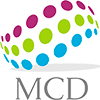

In [42]:
from IPython import display
display.Image("https://mcd.unison.mx/wp-content/themes/awaken/img/logo_mcd.png", embed = True)

<summary>
    <font size="4" color="gray"> Maestría en Ciencia de Datos | Universidad de Sonora </font>
</summary>
<font size="1" color="gray"> Blvd. Luis Encinas y Rosales s/n Col. Centro. Edificio 3K1 planta baja C.P. 83000, Hermosillo, Sonora, México </font>
<font size="1" color="gray"> mcd@unison.mx </font>
<font size="1" color="gray"> Tel: +52 (662) 259 2155  </font>